# O Mninst

Neste exercício, vamos utilizar o Mninst: http://yann.lecun.com/exdb/mnist/

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Fazendo uma normalização simples da base de dados

In [ ]:
# Com arrays numpy, operações aritméticas acontecem ponto a ponto, ou seja, são aplicados em todos os elementos do tensor
X_train = X_train/255 
X_test = X_test/255

In [ ]:
print(X_train.shape) # Notem as dimensões da matriz. Conseguem entender o que 3 dimensões significam?
print(X_train[0].shape)
print(y_train.shape)

(60000, 28, 28)
(28, 28)
(60000,)


# Reduzindo a base dados a 75%

In [ ]:
# Aqui eu ia diminuir a base pra 95%, mas rodei
# Demorou mas foi
# E aí por questões de precisão do banco de testes, deixei assim mesmo
SEED = 28_01_2022 # Equivale a 28012022

X_train, _, y_train, _ = train_test_split(X_train, y_train, 
                                          test_size = .75, 
                                          random_state=SEED, 
                                          stratify=y_train)

In [ ]:
print(X_train.shape)
print(X_train[0].shape)
print(y_train.shape)

(15000, 28, 28)
(28, 28)
(15000,)


# Exibindo  alguns exemplos de dígitos

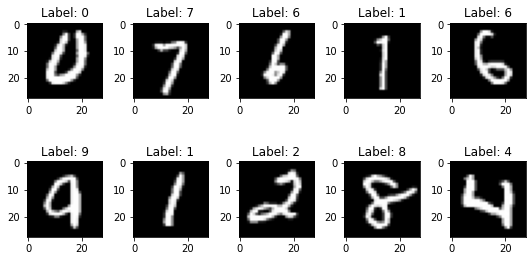

In [ ]:
num = 10
images = X_train[:num] #Obtendo as "num" primeiras imagens
labels = y_train[:num]

num_row = 2
num_col = 5# plot images

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Convertendo matrizes para vetores



*   Há várias formas de transformar uma array numpy para vetores. Aqui, utlizamos seu [método reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)


In [ ]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

In [ ]:
# Observem os métodos
X_train.shape, X_test.shape

((15000, 784), (10000, 784))

**Ou seja, nós temos, para cada exemplo, 784 features!**

# Treinando o modelo com a classe do scikit MLPClassifier

* Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [ ]:
# Como a gente aprendeu na documentação do scikit no exercício lá no strateegia
# Vamos treinar o modelo
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(random_state = SEED)
mlp.fit(X_train, y_train)

MLPClassifier(random_state=28012022)

In [ ]:
accuracy_score(y_test, mlp.predict(X_test))

0.9654

# Validação

* Vamos utilizar o [Grid search do sickit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* O User Guide detalha um pouco mais: https://scikit-learn.org/stable/modules/grid_search.html#grid-search

* O treinamento de fato demora muito mais que os exemplos feitos em sala de aula. Portanto, não estranhem.

In [ ]:
# Aqui eu fiz algumas mudanças
# Adicionei o solver, mais um parâmetro no grid search
# Diminui os ranges e usei valores proporcionais
# Não sei por que mas as camadas do hidden layers sizes funcionam melhor (ou funcionam at all)
# Quando o valor colocado no segundo set de camadas é múltiplo ou divisor do primeiro set, que foi colocado pelo monitor
# Pelo que eu vi na documentação, não faz diferença usar adam, sgd ou ibfgs como defaults no solver
from sklearn.model_selection import GridSearchCV

# Definindo a lista de parâmetros e seus possíveis valores.
# Com o GridSearchCV, um dicionário é definido com os nomes dos parâmetros sendo sua chave
# Cada chave recebe uma lista valores.
# O modelo é treinado com cada combinaçao possível dos parâmetros
# Adicionando um range de duas camadas
# Adicionando o solver para auxiliar o grid search, que tem default "adam" ou "sgd" ou "ibfgs"

parameters = {
    "hidden_layer_sizes": [range(40, 20, 10), range(20, 10)],
    "solver": ['sgd'],
    "activation": ["logistic", "tanh", "relu"],
}


# Notem que a validação agora demora mais que com os modelos que usamos até então.
# Quando atribuímos um número inteiro (quantidade de folds) ao parâmetro cv, a validação cruzada é estratificada, 
# ou seja, ela conserva as proporções originais das classes.
# Mudando cv de 5 para 3 por orientação do monitor

grid_search = GridSearchCV(MLPClassifier(), 
                    parameters,
                    scoring  = "accuracy",
                    n_jobs= -1, 
                    verbose=3,
                    cv = 3)

grid_search.fit(X_train, y_train)
# No output abaixo, notem que foram feitos 60 fits, ou seja, 60 treinamentos.
# Cada combinação de parâmetro é treinada 5 (agora 3) vezes por meio da validação cruzada

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [range(40, 20, 10),
                                                range(20, 10)],
                         'solver': ['sgd']},
             scoring='accuracy', verbose=3)

In [ ]:
# Extraindo os melhores parâmetros
best_params = grid_search.best_params_
# best_params = {'activation': 'relu', 'hidden_layer_sizes': 400}

# Exibindo os dados da validação

In [ ]:
print(best_params)
means = grid_search.cv_results_["mean_test_score"]
stds = grid_search.cv_results_["std_test_score"]

for mean, std, params in zip(means, stds, grid_search.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

{'activation': 'relu', 'hidden_layer_sizes': range(20, 10), 'solver': 'sgd'}
0.828 (+/-0.041) for {'activation': 'logistic', 'hidden_layer_sizes': range(40, 20, 10), 'solver': 'sgd'}
0.832 (+/-0.059) for {'activation': 'logistic', 'hidden_layer_sizes': range(20, 10), 'solver': 'sgd'}
0.828 (+/-0.053) for {'activation': 'tanh', 'hidden_layer_sizes': range(40, 20, 10), 'solver': 'sgd'}
0.824 (+/-0.050) for {'activation': 'tanh', 'hidden_layer_sizes': range(20, 10), 'solver': 'sgd'}
0.820 (+/-0.047) for {'activation': 'relu', 'hidden_layer_sizes': range(40, 20, 10), 'solver': 'sgd'}
0.841 (+/-0.011) for {'activation': 'relu', 'hidden_layer_sizes': range(20, 10), 'solver': 'sgd'}


## Classification report: 

* https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report

In [ ]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.89      0.96      0.93      1135
           2       0.84      0.82      0.83      1032
           3       0.79      0.84      0.82      1010
           4       0.89      0.81      0.85       982
           5       0.87      0.70      0.78       892
           6       0.86      0.91      0.88       958
           7       0.89      0.84      0.86      1028
           8       0.78      0.80      0.79       974
           9       0.78      0.84      0.81      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Retreinando o modelo com os melhores parâmetros

Notem que os resultados são os mesmos dos obtidos quando usamos o predict do grid search

In [ ]:
mlp = MLPClassifier(**best_params)

mlp.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=range(20, 10), solver='sgd')

In [ ]:
print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.86      0.97      0.91      1135
           2       0.90      0.86      0.88      1032
           3       0.90      0.72      0.80      1010
           4       0.84      0.89      0.86       982
           5       0.82      0.81      0.81       892
           6       0.94      0.93      0.94       958
           7       0.91      0.90      0.91      1028
           8       0.78      0.94      0.85       974
           9       0.89      0.78      0.83      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.88      0.87     10000



# Plotando a curva de aprendizado

Neste exemplo, a curva de aprendizando consiste da relação entre a perda (loss) em cada iteração do otimizador

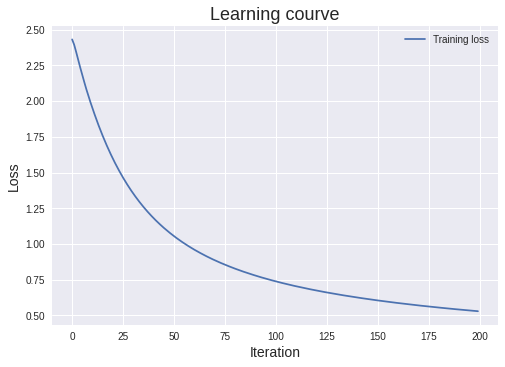

In [ ]:
plt.style.use('seaborn')
plt.plot(range(len(mlp.loss_curve_)), mlp.loss_curve_, label = 'Training loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.title('Learning courve', fontsize = 18)
plt.legend()

# Exercício
Para responder aos exercícios anteriores, basta complementar este notebook ou, se preferir, criar um outro com apenas os experimentos que interessam.

* Executar o grid search nos parâmetros "solver" e "activation". ✅
* Validar com 2 e 3 camadas ocultas (*hidden_layer_sizes*). Vocês devem fixar um tamanho (quantidade de neurônios) para cada camada. Ou seja, não é necessário treinar a quantidade de neurônios por camada. Basta treinar a quantidade de camadas. Por **exemplo**:
  * Para duas camadas vc pode treinar com (20, 10)
  * Para três camadas, vc pode treinar com (40, 20, 10)
  * Os valores anteriores são apenas exemplos. Experimentem tamanhos menores ou maiores. Não necessariamente as primeiras camadas precisam ser maiores que as seguintes. ✅
* O segredo para saber responder o item anterior é entender bem os valores esperados no parâmtro *hidden_layer_sizes*. ✅
* Usar apenas 3 folds na validação cruzada. ✅
* Plotar a curva de aprendizado com o modelo treinado com os melhores parâmetros. ✅



Breves comentários porque já comentei pelo código

- Inicialmente, fugi um pouco da sugestão do monitor, ao invés de usar (40, 20, 10) e (20, 10) usei (10, 20, 40) e (30, 80);
- Notei que, com isso, a queda da curva de aprendizado foi mais brusca no range que escolhi vs o range sugerido pelo monitor, que plotou uma curva mais suave; 
- Fora isso, segui basicamente todas as sugestões;
- Notei que demorou muito mais pra rodar com os ranges que tinham originalmente;
- Também, como coloquei lá em cima, alguns valores não proporcionais deram erro;
- Analisando o treinamento e validação: antes de retreinar sortando os melhores valores, tivemos um resultado final igual entre os três valores, todos com 0.85;
- Percebe-se uma queda maior em precision (14%) em comparação a f1-score (12%) e recall (11%);
- Após o retreinamento, vemos uma mudança de cenário: os valores finais ficam ali num limiar de 0.87 e 0.88, e o detla da taxa de recall aumenta consideravelmente (de 11% para 18%), enquanto o delta da taxa de precision abaixa consideravelmente (de 14% para 5%). O delta da taxa de f1-score permanece 12%
